In [115]:
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver, setsolvefor, addobj, addeq, addineq, OPT
from datastructures.execution import edges_from_components
from datastructures.graphutils import namefromsympy, dfs_tree, SOLVER, VAR, COMP, nested_sources, sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver
from datastructures.nestedgraph import root_sources
from datastructures.execution import generate_components_and_residuals
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.assembly import build_archi
from datastructures.api import evalexpr
from datastructures.postprocess import print_inputs, print_outputs, update_varval
import openmdao.api as om
import numpy as np
from sympy import cos, log
import matplotlib.pyplot as plt

In [116]:
w,x,y,z,a = Var('w',-100), Var('x',-100), Var('y',-100), Var('z',-100), Par('a', 100)

In [148]:
model = Model(solver=OPT)
m = model.root
adda(m, w, log(x**2)+log(y**2)+log(z**2)+100)
adda(m, x, log(y**2)+log(z**2)+100)
adda(m, y, log(z**2)+100-x)
adda(m, z, a)

z

In [149]:
edges, tree = model.generate_formulation()

In [150]:
ordered_tree = tree
ordered_edges = edges
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options[1] = {'solver': 'N', 'maxiter':20}
nodetyperepr = model.nametyperepr
namingfunc = namefromsympy(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [158]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [159]:
recorder = om.SqliteRecorder("cases.sqlite")
solver = prob.model.s1.nonlinear_solver
solver.add_recorder(recorder)

In [160]:
for key,val in ordered_tree[0].items():
    s = groups[namingfunc(val, SOLVER)]
    f = getattr(s, namingfunc(key, COMP))
    f.recording_options['options_excludes'] = ['component']

In [161]:
prob.set_val('w',100)
prob.set_val('x',100)
prob.set_val('y',100)
prob.set_val('z',100)

In [162]:
prob.run_model()


==
s1
==
NL: Newton Converged in 11 iterations


In [156]:
#om.n2(prob)

In [157]:
prob.cleanup();

In [163]:
cr = om.CaseReader("cases.sqlite")
solver_cases = cr.list_cases(out_stream=None);

In [164]:
solver_cases

['rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|Newton_subsolve|0',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|0|Newton_subsolve|0',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|0',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|1|Newton_subsolve|0',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|1',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|2|Newton_subsolve|0',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|2',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|3|Newton_subsolve|0',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|3',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolver|4|Newton_subsolve|0',
 'rank0:root._solve_nonlinear|0|NLRunOnce|0|s1._solve_nonlinear|0|NewtonSolve

In [165]:
[cr.get_case(elt).get_val('w') for elt in solver_cases]

[array([127.63102112]),
 array([120.92733941]),
 array([120.92733941]),
 array([120.7120508]),
 array([120.7120508]),
 array([121.98596591]),
 array([121.98596591]),
 array([118.94438148]),
 array([118.94438148]),
 array([118.22996956]),
 array([118.22996956]),
 array([117.65933688]),
 array([117.65933688]),
 array([117.81777027]),
 array([117.81777027]),
 array([117.87487299]),
 array([117.87487299]),
 array([117.88045257]),
 array([117.88045257]),
 array([117.88049998]),
 array([117.88049998]),
 array([117.88049998])]

In [166]:
[cr.get_case(elt).get_val('x') for elt in solver_cases]

[array([118.42068074]),
 array([111.48449342]),
 array([111.48449342]),
 array([111.38044721]),
 array([111.38044721]),
 array([112.7075215]),
 array([112.7075215]),
 array([109.53638937]),
 array([109.53638937]),
 array([108.82834575]),
 array([108.82834575]),
 array([108.284345]),
 array([108.284345]),
 array([108.44374037]),
 array([108.44374037]),
 array([108.50120929]),
 array([108.50120929]),
 array([108.50682522]),
 array([108.50682522]),
 array([108.50687295]),
 array([108.50687295]),
 array([108.50687295])]

In [167]:
[cr.get_case(elt).get_val('y') for elt in solver_cases]

[array([-9.21034037]),
 array([-2.27415305]),
 array([-2.27415305]),
 array([-2.17010684]),
 array([-2.17010684]),
 array([-3.49718113]),
 array([-3.49718113]),
 array([-0.326049]),
 array([-0.326049]),
 array([0.38199462]),
 array([0.38199462]),
 array([0.92599538]),
 array([0.92599538]),
 array([0.7666]),
 array([0.7666]),
 array([0.70913108]),
 array([0.70913108]),
 array([0.70351515]),
 array([0.70351515]),
 array([0.70346743]),
 array([0.70346743]),
 array([0.70346742])]

In [168]:
[cr.get_case(elt).get_val('z') for elt in solver_cases]

[array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.])]

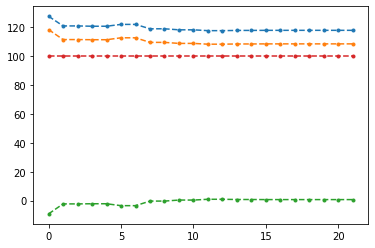

In [169]:
plt.plot([cr.get_case(elt).get_val('w') for elt in solver_cases], '.--')
plt.plot([cr.get_case(elt).get_val('x') for elt in solver_cases], '.--')
plt.plot([cr.get_case(elt).get_val('y') for elt in solver_cases], '.--')
plt.plot([cr.get_case(elt).get_val('z') for elt in solver_cases], '.--');